# Face Generation
In this project, we'll use generative adversarial networks to generate new images of faces.
### Get the Data
We'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex, we would test the neural network on MNIST before CelebA.  Running the GANs on MNIST will allow us to see how well our model trains sooner.

As we are using [FloydHub](https://www.floydhub.com/), we will set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:14<00:00, 4.16KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
It is important to note that the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. We can view the first number of examples by changing `show_n_images`. 

In [5]:
!ls /input -Ltral

total 7724
drwxr-xr-x 109 root root    4096 May 21 00:10 ..
drwxr-xr-x   2 root root 2146304 May 21 00:11 mnist
drwxr-xr-x   2 root root 5754880 May 21 00:12 img_align_celeba
drwxr-xr-x   4 root root    4096 May 21 00:12 .


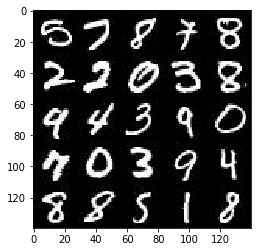

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since we're going to be generating faces, we won't need the annotations.  We can view the first number of examples by changing `show_n_images`.

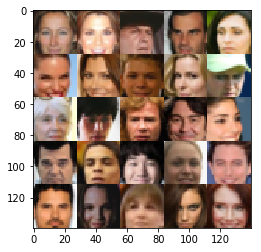

In [7]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
We'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure we have the correct version of TensorFlow and access to a GPU

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
We will implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

We return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [9]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    l_rate = tf.placeholder(tf.float32, name='l_rate')

    return input_real, input_z, l_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [10]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.1
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
   
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
We implement `generator` to generate an image using `z`. This function will reuse the variabes in the neural network.  We use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.1
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
We implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  We use the following functions we implemented before:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    smooth = 0.1
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real)* 
                                                                         (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    # Optimize

    with tf.control_dependencies(gen_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
We use this function to show the current output of the generator during training. It will help us determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
We implement `train` to build and train the GANs.  We use the following functions implemented before:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

We use the `show_generator_output` to show `generator` output while we train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    _ , image_width, image_height, image_channels = data_shape
    image_input, z_input, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(image_input, z_input, len(data_image_mode))
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        steps = 0
        for epoch_i in range(epoch_count):
            
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={image_input: batch_images, z_input: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_input: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_input: batch_z, lr:learning_rate})
                steps +=1
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, image_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 100 == 0:
                    show_generator_output(sess, 25, z_input, image_channels, data_image_mode)
                
                

### MNIST
We test our GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  We should make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8754... Generator Loss: 2.7447
Epoch 1/2... Discriminator Loss: 2.5945... Generator Loss: 0.1714
Epoch 1/2... Discriminator Loss: 2.4237... Generator Loss: 0.2750
Epoch 1/2... Discriminator Loss: 2.1529... Generator Loss: 0.5579
Epoch 1/2... Discriminator Loss: 2.4277... Generator Loss: 0.1966
Epoch 1/2... Discriminator Loss: 2.3522... Generator Loss: 0.1930
Epoch 1/2... Discriminator Loss: 2.2117... Generator Loss: 0.2291
Epoch 1/2... Discriminator Loss: 1.7242... Generator Loss: 0.5124
Epoch 1/2... Discriminator Loss: 1.7349... Generator Loss: 0.4888
Epoch 1/2... Discriminator Loss: 1.6799... Generator Loss: 0.6472


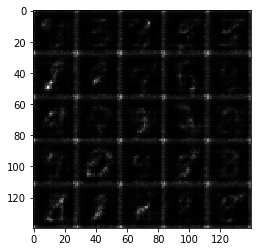

Epoch 1/2... Discriminator Loss: 1.8984... Generator Loss: 0.2816
Epoch 1/2... Discriminator Loss: 1.6349... Generator Loss: 0.8142
Epoch 1/2... Discriminator Loss: 1.5160... Generator Loss: 0.7777
Epoch 1/2... Discriminator Loss: 1.6194... Generator Loss: 0.8656
Epoch 1/2... Discriminator Loss: 1.5109... Generator Loss: 0.7152
Epoch 1/2... Discriminator Loss: 1.9309... Generator Loss: 0.2645
Epoch 1/2... Discriminator Loss: 1.3653... Generator Loss: 1.2554
Epoch 1/2... Discriminator Loss: 1.9575... Generator Loss: 0.2535
Epoch 1/2... Discriminator Loss: 1.6070... Generator Loss: 0.5345
Epoch 1/2... Discriminator Loss: 1.5855... Generator Loss: 0.8369


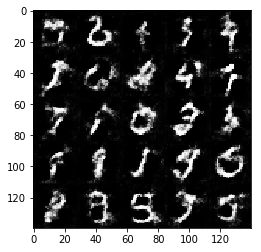

Epoch 1/2... Discriminator Loss: 1.6219... Generator Loss: 0.5501
Epoch 1/2... Discriminator Loss: 1.6710... Generator Loss: 0.3678
Epoch 1/2... Discriminator Loss: 1.8215... Generator Loss: 0.2921
Epoch 1/2... Discriminator Loss: 1.5203... Generator Loss: 1.0728
Epoch 1/2... Discriminator Loss: 1.5972... Generator Loss: 0.6761
Epoch 1/2... Discriminator Loss: 1.8515... Generator Loss: 0.2815
Epoch 1/2... Discriminator Loss: 1.5493... Generator Loss: 0.8711
Epoch 1/2... Discriminator Loss: 1.6029... Generator Loss: 0.4746
Epoch 1/2... Discriminator Loss: 1.6568... Generator Loss: 0.5207
Epoch 1/2... Discriminator Loss: 1.8980... Generator Loss: 0.2864


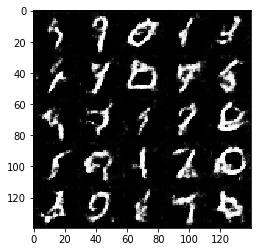

Epoch 1/2... Discriminator Loss: 1.6726... Generator Loss: 0.4166
Epoch 1/2... Discriminator Loss: 1.6450... Generator Loss: 0.5702
Epoch 1/2... Discriminator Loss: 1.4542... Generator Loss: 0.6081
Epoch 1/2... Discriminator Loss: 1.8025... Generator Loss: 0.3414
Epoch 1/2... Discriminator Loss: 1.4891... Generator Loss: 0.5715
Epoch 1/2... Discriminator Loss: 1.4684... Generator Loss: 0.8392
Epoch 1/2... Discriminator Loss: 1.6140... Generator Loss: 0.4804
Epoch 1/2... Discriminator Loss: 1.5857... Generator Loss: 0.4834
Epoch 1/2... Discriminator Loss: 1.5167... Generator Loss: 0.5891
Epoch 1/2... Discriminator Loss: 1.5152... Generator Loss: 0.4766


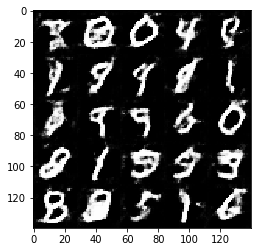

Epoch 1/2... Discriminator Loss: 1.5379... Generator Loss: 0.5040
Epoch 1/2... Discriminator Loss: 1.5631... Generator Loss: 0.4667
Epoch 1/2... Discriminator Loss: 1.5303... Generator Loss: 0.5786
Epoch 1/2... Discriminator Loss: 1.4258... Generator Loss: 0.5954
Epoch 1/2... Discriminator Loss: 1.4835... Generator Loss: 0.6672
Epoch 1/2... Discriminator Loss: 1.5313... Generator Loss: 0.4626
Epoch 1/2... Discriminator Loss: 1.5849... Generator Loss: 0.4200
Epoch 1/2... Discriminator Loss: 1.5984... Generator Loss: 0.4564
Epoch 1/2... Discriminator Loss: 1.5906... Generator Loss: 0.4634
Epoch 1/2... Discriminator Loss: 1.5842... Generator Loss: 0.5501


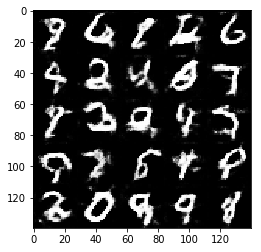

Epoch 1/2... Discriminator Loss: 1.4690... Generator Loss: 0.5445
Epoch 1/2... Discriminator Loss: 1.5886... Generator Loss: 0.4504
Epoch 1/2... Discriminator Loss: 1.5993... Generator Loss: 0.4240
Epoch 1/2... Discriminator Loss: 1.4581... Generator Loss: 0.6503
Epoch 1/2... Discriminator Loss: 1.5766... Generator Loss: 0.4447
Epoch 1/2... Discriminator Loss: 1.5608... Generator Loss: 0.4448
Epoch 1/2... Discriminator Loss: 1.3189... Generator Loss: 0.7030
Epoch 1/2... Discriminator Loss: 1.4575... Generator Loss: 0.8880
Epoch 1/2... Discriminator Loss: 1.4473... Generator Loss: 0.6647
Epoch 1/2... Discriminator Loss: 1.5760... Generator Loss: 0.4578


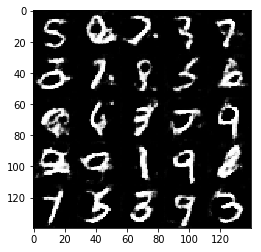

Epoch 1/2... Discriminator Loss: 1.5650... Generator Loss: 0.4905
Epoch 1/2... Discriminator Loss: 1.5110... Generator Loss: 0.9001
Epoch 1/2... Discriminator Loss: 1.5202... Generator Loss: 0.5016
Epoch 1/2... Discriminator Loss: 1.9210... Generator Loss: 0.2663
Epoch 1/2... Discriminator Loss: 1.5258... Generator Loss: 0.5353
Epoch 1/2... Discriminator Loss: 1.5039... Generator Loss: 0.5054
Epoch 1/2... Discriminator Loss: 1.6169... Generator Loss: 0.4766
Epoch 1/2... Discriminator Loss: 1.7775... Generator Loss: 0.3286
Epoch 1/2... Discriminator Loss: 1.7257... Generator Loss: 0.3613
Epoch 1/2... Discriminator Loss: 1.5485... Generator Loss: 0.4167


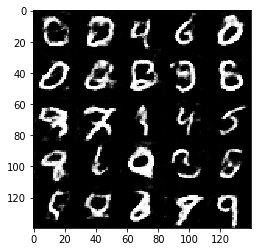

Epoch 1/2... Discriminator Loss: 1.4357... Generator Loss: 0.6663
Epoch 1/2... Discriminator Loss: 1.4614... Generator Loss: 0.6668
Epoch 1/2... Discriminator Loss: 1.5236... Generator Loss: 0.7010
Epoch 1/2... Discriminator Loss: 1.5605... Generator Loss: 0.4639
Epoch 1/2... Discriminator Loss: 1.5077... Generator Loss: 0.6899
Epoch 1/2... Discriminator Loss: 1.5528... Generator Loss: 0.6270
Epoch 1/2... Discriminator Loss: 1.4735... Generator Loss: 0.5414
Epoch 1/2... Discriminator Loss: 1.5653... Generator Loss: 0.5967
Epoch 1/2... Discriminator Loss: 1.5509... Generator Loss: 0.5588
Epoch 1/2... Discriminator Loss: 1.7028... Generator Loss: 0.3503


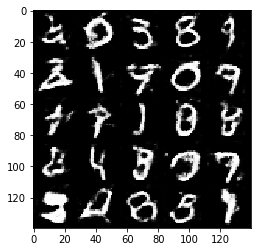

Epoch 1/2... Discriminator Loss: 1.7001... Generator Loss: 0.3651
Epoch 1/2... Discriminator Loss: 1.5404... Generator Loss: 0.5272
Epoch 1/2... Discriminator Loss: 1.5015... Generator Loss: 0.5215
Epoch 1/2... Discriminator Loss: 1.4844... Generator Loss: 0.4808
Epoch 1/2... Discriminator Loss: 1.5525... Generator Loss: 0.4443
Epoch 1/2... Discriminator Loss: 1.4181... Generator Loss: 0.6081
Epoch 1/2... Discriminator Loss: 1.4904... Generator Loss: 0.5553
Epoch 1/2... Discriminator Loss: 1.4862... Generator Loss: 0.6682
Epoch 1/2... Discriminator Loss: 1.4968... Generator Loss: 0.7038
Epoch 1/2... Discriminator Loss: 1.5791... Generator Loss: 0.4389


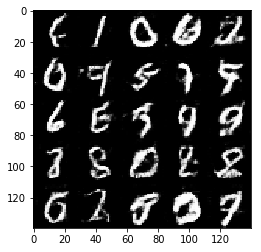

Epoch 1/2... Discriminator Loss: 1.5259... Generator Loss: 0.4689
Epoch 1/2... Discriminator Loss: 1.4583... Generator Loss: 0.6650
Epoch 1/2... Discriminator Loss: 1.6722... Generator Loss: 0.4005
Epoch 2/2... Discriminator Loss: 1.4473... Generator Loss: 0.5988
Epoch 2/2... Discriminator Loss: 1.5643... Generator Loss: 0.5105
Epoch 2/2... Discriminator Loss: 1.5622... Generator Loss: 0.4695
Epoch 2/2... Discriminator Loss: 1.4586... Generator Loss: 0.5546
Epoch 2/2... Discriminator Loss: 1.6194... Generator Loss: 0.4043
Epoch 2/2... Discriminator Loss: 1.3687... Generator Loss: 0.6706
Epoch 2/2... Discriminator Loss: 1.5397... Generator Loss: 0.4208


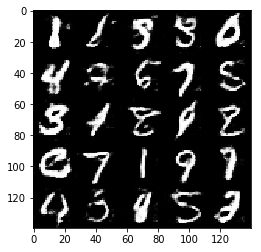

Epoch 2/2... Discriminator Loss: 1.4554... Generator Loss: 0.9277
Epoch 2/2... Discriminator Loss: 1.5218... Generator Loss: 0.4659
Epoch 2/2... Discriminator Loss: 1.6788... Generator Loss: 0.3730
Epoch 2/2... Discriminator Loss: 1.5335... Generator Loss: 1.1802
Epoch 2/2... Discriminator Loss: 1.4158... Generator Loss: 0.6079
Epoch 2/2... Discriminator Loss: 1.3405... Generator Loss: 0.5922
Epoch 2/2... Discriminator Loss: 2.0155... Generator Loss: 0.2369
Epoch 2/2... Discriminator Loss: 1.5155... Generator Loss: 0.4869
Epoch 2/2... Discriminator Loss: 1.3593... Generator Loss: 0.8516
Epoch 2/2... Discriminator Loss: 1.4753... Generator Loss: 0.4660


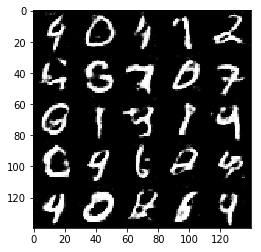

Epoch 2/2... Discriminator Loss: 1.4126... Generator Loss: 0.6700
Epoch 2/2... Discriminator Loss: 1.8662... Generator Loss: 1.4545
Epoch 2/2... Discriminator Loss: 1.4849... Generator Loss: 0.5224
Epoch 2/2... Discriminator Loss: 1.5364... Generator Loss: 0.5350
Epoch 2/2... Discriminator Loss: 1.5354... Generator Loss: 0.4501
Epoch 2/2... Discriminator Loss: 1.5446... Generator Loss: 0.4444
Epoch 2/2... Discriminator Loss: 1.3920... Generator Loss: 0.5782
Epoch 2/2... Discriminator Loss: 1.4427... Generator Loss: 0.5629
Epoch 2/2... Discriminator Loss: 1.5510... Generator Loss: 0.4288
Epoch 2/2... Discriminator Loss: 1.5562... Generator Loss: 0.4167


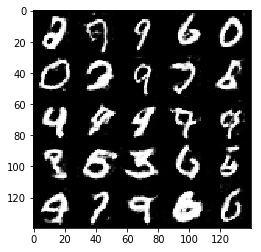

Epoch 2/2... Discriminator Loss: 1.4996... Generator Loss: 0.5536
Epoch 2/2... Discriminator Loss: 1.4164... Generator Loss: 0.6303
Epoch 2/2... Discriminator Loss: 1.8148... Generator Loss: 0.3304
Epoch 2/2... Discriminator Loss: 1.3303... Generator Loss: 0.7004
Epoch 2/2... Discriminator Loss: 1.3555... Generator Loss: 0.5716
Epoch 2/2... Discriminator Loss: 1.4932... Generator Loss: 0.6673
Epoch 2/2... Discriminator Loss: 1.4422... Generator Loss: 1.1174
Epoch 2/2... Discriminator Loss: 1.5644... Generator Loss: 0.4589
Epoch 2/2... Discriminator Loss: 1.3205... Generator Loss: 0.6103
Epoch 2/2... Discriminator Loss: 1.4606... Generator Loss: 0.4702


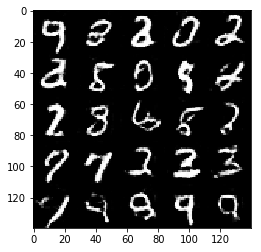

Epoch 2/2... Discriminator Loss: 1.4111... Generator Loss: 0.6480
Epoch 2/2... Discriminator Loss: 1.4400... Generator Loss: 0.5215
Epoch 2/2... Discriminator Loss: 1.2949... Generator Loss: 0.7298
Epoch 2/2... Discriminator Loss: 1.4312... Generator Loss: 0.5486
Epoch 2/2... Discriminator Loss: 1.2972... Generator Loss: 0.8778
Epoch 2/2... Discriminator Loss: 2.0648... Generator Loss: 0.2262
Epoch 2/2... Discriminator Loss: 2.3802... Generator Loss: 0.1716
Epoch 2/2... Discriminator Loss: 1.2587... Generator Loss: 0.6817
Epoch 2/2... Discriminator Loss: 1.2129... Generator Loss: 0.8864
Epoch 2/2... Discriminator Loss: 1.4474... Generator Loss: 0.4810


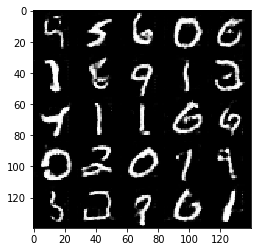

Epoch 2/2... Discriminator Loss: 1.3874... Generator Loss: 0.6537
Epoch 2/2... Discriminator Loss: 1.6199... Generator Loss: 0.3972
Epoch 2/2... Discriminator Loss: 1.2636... Generator Loss: 0.6578
Epoch 2/2... Discriminator Loss: 1.2929... Generator Loss: 0.7114
Epoch 2/2... Discriminator Loss: 1.7728... Generator Loss: 0.3139
Epoch 2/2... Discriminator Loss: 1.4858... Generator Loss: 0.8790
Epoch 2/2... Discriminator Loss: 1.2530... Generator Loss: 1.1981
Epoch 2/2... Discriminator Loss: 1.3854... Generator Loss: 0.5409
Epoch 2/2... Discriminator Loss: 1.4056... Generator Loss: 0.6091
Epoch 2/2... Discriminator Loss: 1.7178... Generator Loss: 0.3513


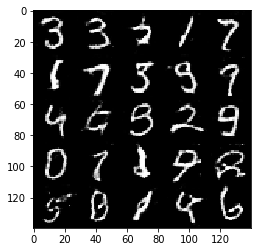

Epoch 2/2... Discriminator Loss: 1.7512... Generator Loss: 0.3492
Epoch 2/2... Discriminator Loss: 1.2539... Generator Loss: 0.9106
Epoch 2/2... Discriminator Loss: 1.2628... Generator Loss: 0.8015
Epoch 2/2... Discriminator Loss: 1.4568... Generator Loss: 0.6455
Epoch 2/2... Discriminator Loss: 1.2585... Generator Loss: 0.7004
Epoch 2/2... Discriminator Loss: 1.2503... Generator Loss: 0.6571
Epoch 2/2... Discriminator Loss: 1.1215... Generator Loss: 1.1087
Epoch 2/2... Discriminator Loss: 1.6214... Generator Loss: 1.1082
Epoch 2/2... Discriminator Loss: 1.4026... Generator Loss: 0.6449
Epoch 2/2... Discriminator Loss: 1.7595... Generator Loss: 0.3193


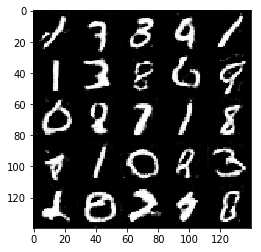

Epoch 2/2... Discriminator Loss: 1.3959... Generator Loss: 1.2129
Epoch 2/2... Discriminator Loss: 1.4816... Generator Loss: 0.4915
Epoch 2/2... Discriminator Loss: 1.3293... Generator Loss: 0.8656
Epoch 2/2... Discriminator Loss: 1.2510... Generator Loss: 0.6879
Epoch 2/2... Discriminator Loss: 1.4326... Generator Loss: 0.4952
Epoch 2/2... Discriminator Loss: 1.3791... Generator Loss: 0.5648
Epoch 2/2... Discriminator Loss: 1.3185... Generator Loss: 0.7236
Epoch 2/2... Discriminator Loss: 1.4947... Generator Loss: 0.4773
Epoch 2/2... Discriminator Loss: 1.7076... Generator Loss: 1.0574
Epoch 2/2... Discriminator Loss: 1.2387... Generator Loss: 0.8401


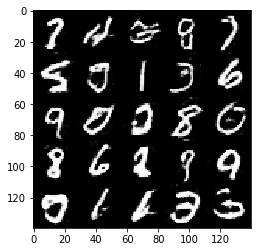

Epoch 2/2... Discriminator Loss: 1.3136... Generator Loss: 0.7577
Epoch 2/2... Discriminator Loss: 1.1344... Generator Loss: 0.8475
Epoch 2/2... Discriminator Loss: 1.5236... Generator Loss: 0.4436
Epoch 2/2... Discriminator Loss: 1.4130... Generator Loss: 0.9412
Epoch 2/2... Discriminator Loss: 1.3012... Generator Loss: 0.6000
Epoch 2/2... Discriminator Loss: 1.3074... Generator Loss: 0.7213
Epoch 2/2... Discriminator Loss: 1.4556... Generator Loss: 0.5294
Epoch 2/2... Discriminator Loss: 1.3801... Generator Loss: 0.6680
Epoch 2/2... Discriminator Loss: 1.5928... Generator Loss: 1.8173
Epoch 2/2... Discriminator Loss: 1.3977... Generator Loss: 0.5825


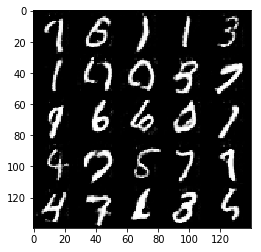

Epoch 2/2... Discriminator Loss: 1.3199... Generator Loss: 0.6299
Epoch 2/2... Discriminator Loss: 1.5881... Generator Loss: 0.3982
Epoch 2/2... Discriminator Loss: 1.2036... Generator Loss: 0.7912
Epoch 2/2... Discriminator Loss: 1.6763... Generator Loss: 0.3995
Epoch 2/2... Discriminator Loss: 1.2000... Generator Loss: 1.0567
Epoch 2/2... Discriminator Loss: 1.7357... Generator Loss: 0.3316
Epoch 2/2... Discriminator Loss: 1.5685... Generator Loss: 0.4158


In [17]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
We run our GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  We can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.6536... Generator Loss: 0.0687
Epoch 1/1... Discriminator Loss: 3.6288... Generator Loss: 0.0629
Epoch 1/1... Discriminator Loss: 2.4478... Generator Loss: 0.3147
Epoch 1/1... Discriminator Loss: 2.3047... Generator Loss: 0.3593
Epoch 1/1... Discriminator Loss: 1.8170... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 1.9273... Generator Loss: 0.4942
Epoch 1/1... Discriminator Loss: 1.9280... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.9667
Epoch 1/1... Discriminator Loss: 1.7560... Generator Loss: 0.5516
Epoch 1/1... Discriminator Loss: 1.7660... Generator Loss: 0.5067


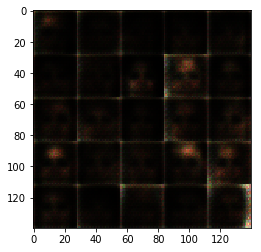

Epoch 1/1... Discriminator Loss: 2.0341... Generator Loss: 0.3139
Epoch 1/1... Discriminator Loss: 1.7053... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.7409... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 1.5643... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.6383... Generator Loss: 0.5019
Epoch 1/1... Discriminator Loss: 2.2264... Generator Loss: 0.3282
Epoch 1/1... Discriminator Loss: 1.6267... Generator Loss: 0.4736
Epoch 1/1... Discriminator Loss: 1.8079... Generator Loss: 0.5332
Epoch 1/1... Discriminator Loss: 1.9206... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 0.7970


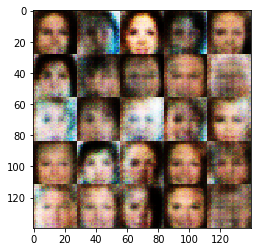

Epoch 1/1... Discriminator Loss: 1.8093... Generator Loss: 0.3430
Epoch 1/1... Discriminator Loss: 1.9823... Generator Loss: 0.3141
Epoch 1/1... Discriminator Loss: 1.6642... Generator Loss: 0.5051
Epoch 1/1... Discriminator Loss: 1.8689... Generator Loss: 0.3554
Epoch 1/1... Discriminator Loss: 1.7250... Generator Loss: 0.5814
Epoch 1/1... Discriminator Loss: 1.5754... Generator Loss: 0.5697
Epoch 1/1... Discriminator Loss: 1.6498... Generator Loss: 0.5190
Epoch 1/1... Discriminator Loss: 1.5354... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 1.5880... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 1.0650


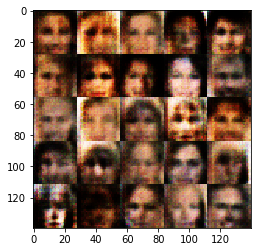

Epoch 1/1... Discriminator Loss: 1.5772... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 1.7495
Epoch 1/1... Discriminator Loss: 1.7008... Generator Loss: 0.5435
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.9839
Epoch 1/1... Discriminator Loss: 1.5803... Generator Loss: 0.5151
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.8705
Epoch 1/1... Discriminator Loss: 1.6709... Generator Loss: 0.5270
Epoch 1/1... Discriminator Loss: 1.5206... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.5990... Generator Loss: 0.5750
Epoch 1/1... Discriminator Loss: 1.6514... Generator Loss: 0.6213


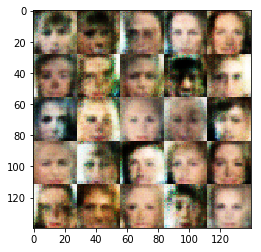

Epoch 1/1... Discriminator Loss: 1.5673... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.5225... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.5659... Generator Loss: 0.5595
Epoch 1/1... Discriminator Loss: 1.5207... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.5654... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.5045... Generator Loss: 0.6358


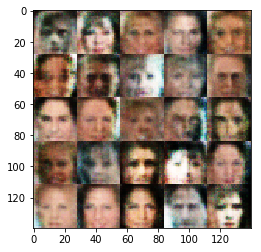

Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.5458... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 1.5983... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.5046... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.7348


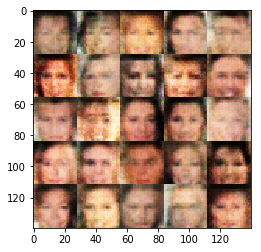

Epoch 1/1... Discriminator Loss: 1.5468... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.5378... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.5128... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.7415


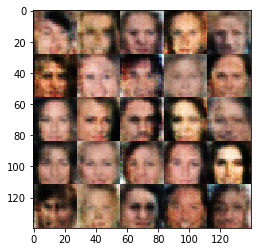

Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.4892... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.5527... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.5306... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.7158


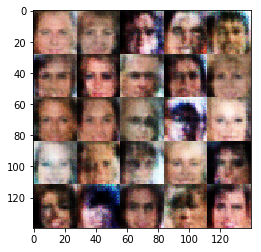

Epoch 1/1... Discriminator Loss: 1.5280... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.5250... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7648


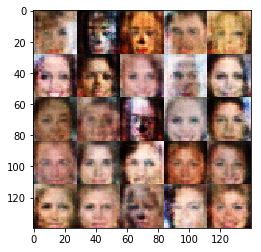

Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.7169


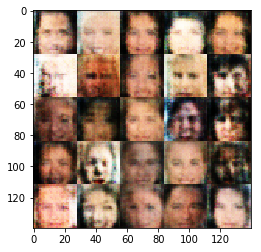

Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.7033


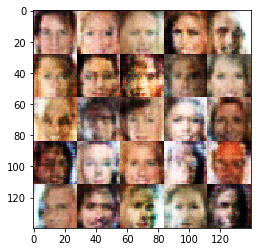

Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.7326


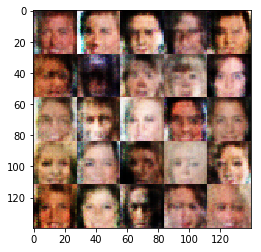

Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.7364


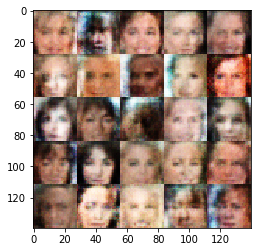

Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.7555


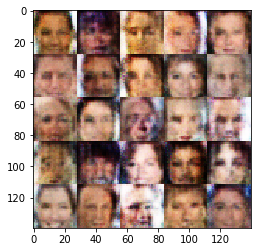

Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.5046... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7187


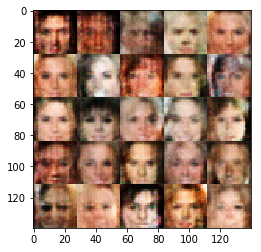

Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.7618


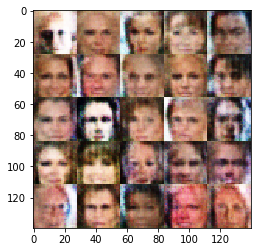

Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.8269


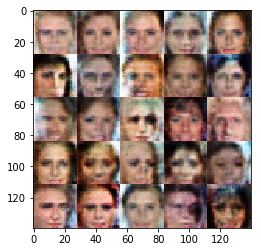

Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.6989


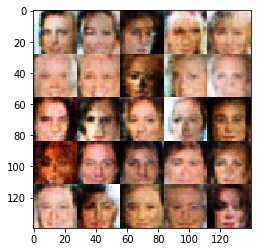

Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.7288


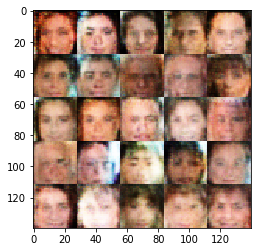

Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7612


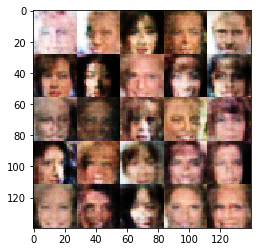

Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.7187


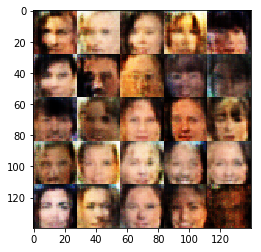

Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.7070


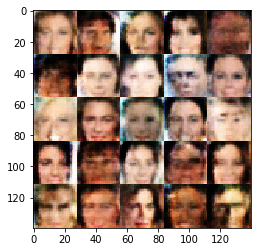

Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.8093


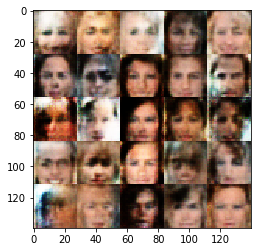

Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.7788


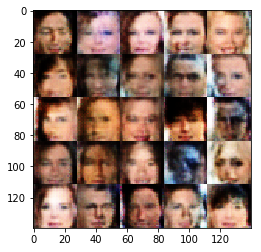

Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.7476


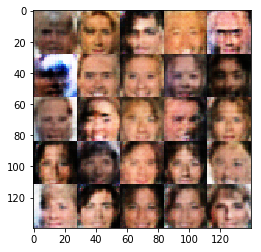

Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.8117


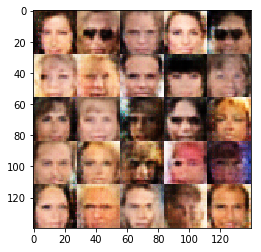

Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.5176... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7261


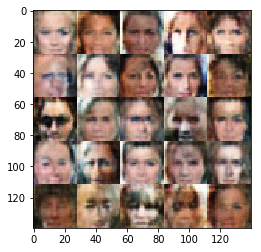

Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.6968


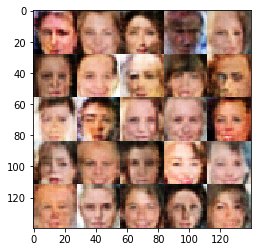

Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.7544


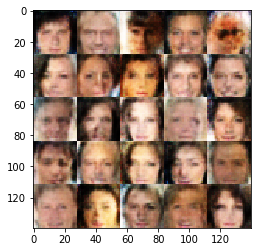

Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7528


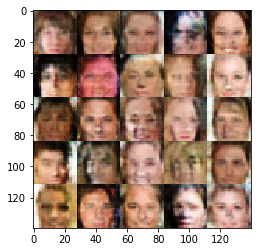

Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.7581


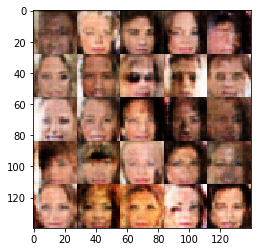

Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.8354


In [18]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)